In [1]:
import librosa
import numpy as np
import soundfile as sf
import torch

from os import path
from torch.autograd import Variable

from NeuralStyleTransfer import CNNModel, GramMatrix, StyleLoss
from utils import plot_spectrum, read_audio_spectum, run_style_transfer

DURATION = 16
N_FFT = 2048

In [2]:
content_fname = "johntejada-1"
style_fname = "beat-box-1"

content_path = path.join("./wavs/corpus", content_fname + ".wav")
style_path = path.join("./wavs/target", style_fname + ".wav")

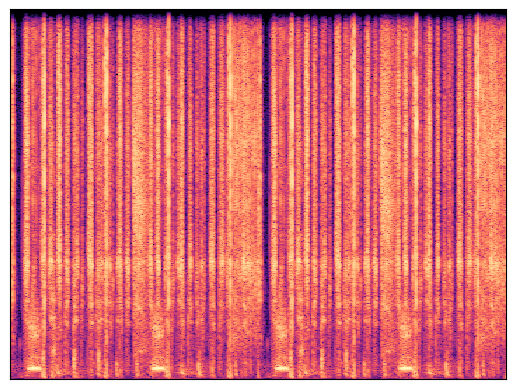

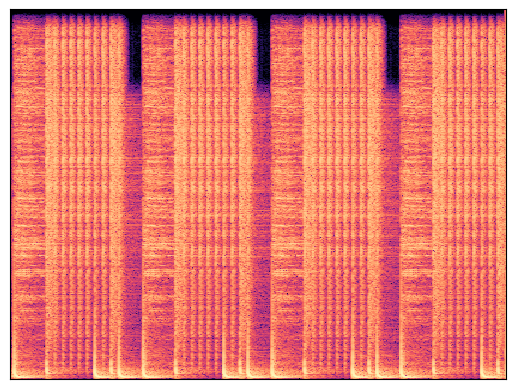

In [3]:
style_audio, style_sr = read_audio_spectum(style_path, duration=DURATION, n_fft=N_FFT)
content_audio, content_sr = read_audio_spectum(content_path, duration=DURATION, n_fft=N_FFT)

plot_spectrum(style_audio)
plot_spectrum(content_audio)

In [4]:
num_samples = min(style_audio.shape[1], content_audio.shape[1])

style_audio = style_audio[:, :num_samples].reshape([1, 1025, num_samples])
content_audio = content_audio[:, :num_samples].reshape([1, 1025, num_samples])

if(content_sr == style_sr):
    print('Sampling Rates are same')
else:
    print('Sampling rates are not same')

Sampling Rates are same


In [5]:
cnn = CNNModel()

if torch.cuda.is_available():
    cnn = cnn.cuda()
    style_float = Variable((torch.from_numpy(style_audio)).cuda())
    content_float = Variable((torch.from_numpy(content_audio)).cuda())	
else:
    style_float = Variable(torch.from_numpy(style_audio))
    content_float = Variable(torch.from_numpy(content_audio))


In [6]:
input_float = content_float.clone()

num_steps = 2500
style_weight = 2500

output = run_style_transfer(
    cnn,
    style_float,
    input_float,
    num_steps=num_steps,
    style_weight=style_weight,
    style_layers=['conv_1'],
    lr=0.03)

if torch.cuda.is_available():
    output = output.cpu()


Building the style transfer model..
Optimizing..
run [100]:
Style Loss : 0.000004

run [200]:
Style Loss : 0.000002

run [300]:
Style Loss : 0.000002

run [400]:
Style Loss : 0.000001

run [500]:
Style Loss : 0.000001

run [600]:
Style Loss : 0.000001

run [700]:
Style Loss : 0.000001

run [800]:
Style Loss : 0.000001

run [900]:
Style Loss : 0.000001

run [1000]:
Style Loss : 0.000001

run [1100]:
Style Loss : 0.000001

run [1200]:
Style Loss : 0.000001

run [1300]:
Style Loss : 0.000001

run [1400]:
Style Loss : 0.000001

run [1500]:
Style Loss : 0.000000

run [1600]:
Style Loss : 0.000000

run [1700]:
Style Loss : 0.000000

run [1800]:
Style Loss : 0.000000

run [1900]:
Style Loss : 0.000000

run [2000]:
Style Loss : 0.000000

run [2100]:
Style Loss : 0.000000

run [2200]:
Style Loss : 0.000000

run [2300]:
Style Loss : 0.000000

run [2400]:
Style Loss : 0.000000

run [2500]:
Style Loss : 0.000000



In [ ]:
output_np = output.squeeze(0).numpy()

a = np.zeros_like(output_np)
a = np.exp(output_np) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j * p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, n_fft=N_FFT))

output_fname = f'output1D-4096_iter-{num_steps}_c-{content_fname}_s-{style_fname}_sw-{style_weight}_k3s1p1.wav'
sf.write(output_fname, x, style_sr)